# Lab 10: Long Short Term Memory (LSTM) Models

Today we will build a chatbot using the PyTorch LSTM cell.

The material in this lab comes from several sources:
- Hands-On Natural Language Processing with Pytorch 1.x, PacktPub
- https://d2l.ai/chapter_recurrent-modern/beam-search.html
- https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html
- https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
- https://github.com/usmanali414/Chatbot-using-Pytorch-LSTM (source code)

## What is the LSTM?

Simple RNNs (SRNs) like we used in Lab 09
have difficulty retaining information over a long period of time. LSTM addresses some of the issues arising
in SRNs. LSTM adds two gates to the typical SRN: an *update gate* and a *forget gate*. These two gates help a network
learn long-term dependencies, for example, so that it can remember the relevant words within a sentence while ignoring
all the irrelevant information.

At a high level,
LSTMs are similar in structure to SRNs. Like SRNs, LSTMs propagate a hidden state from step to step.
However, the inner details of an LSTM cell are quite different from the SRN.

<img src="img/LSTM2.png" title="LSTM" width=200/>

## LSTM cell

The inner workings of an LSTM cell are significantly more complicated. At time step
$t$, the processing looks like this:

<img src="img/LSTMcell2.jpg" title="LSTM cell" style="width: 800px;" />

The hidden state $h_t$ is the actual output of the layer that is passed
on to any later layers. It is obtained from
the internal cell state $c_t$ after it is modulated by the output gate.
The cell state $c_t$ is cell's internal state. It may be partially or
completely cleared by the forget gate, then the new input may be written
to it, under the control of the input gate.

### Forget gate

The forget gate can preserve or attenutate the previous cell state.
It is highlighted in the bold rectangle:

<img src="img/lstm_forgetgate2.png" title="Forget gate" style="width: 480px;" />

Forget gate processing:

$f_t = \sigma(W_{if}x_t + b_{if} + W_{hf}h_{t-1} + b_{hf})$

$c'_t = f_t \odot c_{t-1}$

Note that $\odot$ here means pointwise multiplication of two equal-length vectors and
that the attenuation of the previous cell state is dependent on both the current input
and the previous hidden state.

### Input gate

The input gate allows a value depending on the current input and previous hidden state
to be added to the partly forgotten previous cell state $c'_t$ to obtain the new cell state
$c_t$. However, the addition of the new information to the cell state is controlled by
a multiplicative gate just like the forget gate that also depends on the input and previous
hidden state. The input gate is highlighted in the bold rectangle here:

<img src="img/lstm_inputgate2.jpg" title="Input gate" style="width: 480px;" />

Input gate processing:

$i_t = \sigma(W_{ii}x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})$

$c^+_t = \tanh(W_{ic}x_t + b_{ic} + W_{hc}h_{t-1} + b_{hc})$

$c_t = c'_t + i_t \odot c^+_t$

### Output gate

The hidden state $h_t$, already explained above, is a value output by the
cell that is used by any later layers at the current
time step. The output gate allows some or all of the current
cell state to be propagated to the next step as the hidden state.
We can think of the output $h_t$ as a (possibly attentuated) copy of
the current cell state. The output gate controls this
attentuation. It is highlighted in the bold rectangle:

<img src="img/lstm_outputgate2.png" title="Output gate" style="width: 480px;" />

Output gate processing:

$o_t=\sigma(W_{io}x_t + b_{io} + W_{ho}h_{t-1} + b_{ho})$

$h_t=o_t \cdot \tanh(c_t)$

### Summary

In summary, The LSTM cell performs the following computations:

$i_t=\sigma(W_{ii}x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})$

$f_t=\sigma(W_{if}x_t + b_{if} + W_{hf}h_{t-1} + b_{hf})$

$c^+_t = \tanh(W_{ic}x_t + b_{ic} + W_{hc}h_{t-1} + b_{hc})$

$o_t=\sigma(W_{io}x_t + b_{io} + W_{ho}h_{t-1} + b_{ho})$

$c_t=f_t \odot c_{t-1} + i_t \odot c^+_t$

$h_t=o_t \odot \tanh(c_t)$

## LSTM code example

OK, now let's look at an example of how we might make our own LSTM
cell in PyTorch:

In [5]:
import math
import torch
from torch import nn

class NaiveCustomLSTM(nn.Module):
    
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        # Parameters for computing i_t
        self.U_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing f_t
        self.U_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing c_t
        self.U_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing o_t
        self.U_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.normal_(mean=0, std=stdv)
         
    def forward(self, x, init_states=None):
        """
        forward: Run input x through the cell. Assumes x.shape is (batch_size, sequence_length, input_size)
        """
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            h_t, c_t = init_states
            
        for t in range(seq_sz):
            x_t = x[:, t, :]
            
            i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
            f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
            g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
            o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            hidden_seq.append(h_t.unsqueeze(0))
        
        # Reshape hidden_seq tensor to (batch size, sequence length, hidden_size)
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq, (h_t, c_t)

## Building our chatbot

A chatbot, given input text, should output an appropriate sequence of tokens. One reasonable strategy would
be to output, given input sequence $x$, the sequence maximizing $P(y \mid x)$ using a generative model with
parameters learned from a dataset using maximum likelihood.

We know that $$P(y \mid x) = \prod_{t = 1}^T P(y_t | y_1, \ldots, y_{t-1}, x)$$.

We'll use an LSTM cell as our model of $P(y_t | y_1, \ldots, y_{t-1}, x)$.
One (bad) strategy to find the optimal output for $x$ would be to randomly sample ouput token sequences $y$, calculate
$P(y \mid x)$, and repeat, finally returning the sequence with the highest probability.

A better strategy, however, would be a smarter search procedure. 
We'll go through two search methods: *greedy search* and *beam search*.

### Greedy search

Greedy search is a simple strategy. At time step $t'$ of the output sequence, given the previous tokens and a representation
$c$ of the input, the token with the highest predicted probability from the set of possible tokens $\gamma$ is selected:

$$y_{t'}=\underset{y\in\gamma}{\textrm{argmax}} P(y \mid y_1,...,y_{t'-1},c).$$

We'll allow two strategies to end the sequence: if the token
`<eos>` is output, we stop immediately; otherwise, we keep generating outputs until a maximum output sentence length $T'$ is reached.

The disadvantage of this greedy search method is that the actual optimal sequence $y^*$ will contain some locally suboptimal steps.
To give some intuition, consider a game like chess. We have to sacrifice some of our own pieces (short term suboptimality) in order to obtain a long
term advantage and win the game. Similarly, when selecting an output sentence for our chatbot, some of the tokens in the optimal sequence may have a
relatively low probability given the previous sequence.

Here's how greedy search works:

<img src="img/lstm_greedysearch.PNG" title="At each time step, greedy search selects the token with the highest conditional probability" style="width: 240px;" />

We have four tokens `A`, `B`, `C`, and `<eos>` in the output dictionary. The four numbers under each time step represent conditional probabilities of generating
`A`, `B`, `C`, and `<eos>` at that time step, given the blue highlighted token was selected for the previous time step, respectively.

At each time step, greedy search selects the token with the highest conditional probability. Therefore, the sequence
`A`, `B`, `C`, and `<eos>` will be ouptut. The conditional probability of this output sequence is $0.5 \times 0.4 \times 0.4 \times 0.6 = 0.048$.

In another example, suppose that at time step 2, we select the token `C`, which has the second highest conditional probability:
When `C` is selected at step 2, the conditional probabilities at step 3 will change. Suppose we obtain the following probabilities
and then continue selecting the greedy optimal tokens on step 3 and 4:

<img src="img/lstm_greedysearch2.PNG" title="At time step 2, the token “C”, which has the second highest conditional probability, is selected" style="width: 240px;" />

In this case, we obtain a conditional probability $0.5 \times 0.3 \times 0.6 \times 0.6 = 0.054$, which is larger than what we got from the greedy search. In this example, greedy search is clearly suboptimal.

OK, we'll begin with greedy search then introduce a more sophisticated search procedure, beam
search. For now, let's start implementing our chatbot. First, we pull in some imports and find the GPU:

In [6]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pickle
from torch.autograd import Variable

CUDA = torch.cuda.is_available()
device = torch.device("cuda:2" if CUDA else "cpu")
device

device(type='cuda', index=2)

### Load and preprocess the data

The [Cornell Movie-Dialogs
Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html)
is a rich dataset of movie character dialogs with the following statistics:
-  220,579 conversational exchanges between 10,292 pairs of movie
   characters
-  9035 characters from 617 movies
-  304,713 total utterances

The dataset is large and diverse, with great variation in
language formality, time periods, sentiment, and so on. This
diversity will hopefully let us build a model that can handle
many different contexts.

The [PyTorch chatbot tutorial](https://pytorch.org/tutorials/beginner/chatbot_tutorial.html)
shows how to preprocess the raw Movie Dialogs dataset. We've done this for you already.

Next, note that we are dealing with sequences of words, which cannot be directly
mapped to a continuous vector space as we need for LSTMs. We will therefore create a mapping
from each unique word in the dataset to an index value. (Note that in the readings in class we've seen
better ways to handle natural language vocabularies!)
To perform our simple version of the mapping, we define a class `Voc`. It
creates both the forward mapping from words to indices and the reverse mapping from
indices back to words, as well as a count of each word and a total word count.
The class's behavior includes a method to add a word to the vocabulary (`addWord`), a
method to add all words in a sentence at once
(`addSentence`), and a method to trim infrequently seen words (`trim`). We'll discuss
trimming more later. Here it is:


In [7]:
# Reserved word tokens

PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:

    def __init__(self):        
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold

    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries

        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

Now we can run through the dataset and assemble our vocabulary,
as well as the training query/response sentence pairs.
Before we can use the data, we have to perform some
preprocessing. First, we convert Unicode strings to ASCII using
`unicodeToAscii`. Then we convert every letter to lowercase and
trim all non-letter characters except for basic punctuation
(function `normalizeString`). Finally, to improve training convergence,
we filter out sentences with length greater than the `MAX_LENGTH`
threshold (function `filterPairs`).

In [8]:
MAX_LENGTH = 10  # Maximum sentence length to consider

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a Voc object

def readVocs(datafile):
    print("Reading lines...")    
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc()
    return voc, pairs

# Boolean function returning True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold

def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using the filterPair predicate

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list

def loadPrepareData(datafile):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs

With those routines specficied, now we read chat dataset file, preprocess it, and mold it into pairs of question-answer sentences.

In [9]:
# wget https://github.com/dsai-asia/RTML/raw/main/Labs/11-LSTMs/chatDataset.txt

# Load/Assemble Voc and pairs

datafile = 'chatDataset.txt'
voc, pairs = loadPrepareData(datafile)

# Print some pairs to validate

print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64271 sentence pairs
Counting words...
Counted words: 18008

pairs:
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']


As already mentioned, we will trim out rarely-used
words from the vocabulary. This will help improve convergence during
training, because with a lower-dimensional input feature space, it will be easier
to estimate the probability model $P(y \mid x)$. We trim as a two-step
process:

1. Trim words appearing fewer than `MIN_COUNT` times with the previously-given `Voc.trim`
   method.

2. Filter out all sentence pairs containing trimmed words.

In [11]:

MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs

# Trim vocabulary and pairs

pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7823 / 18005 = 0.4345
Trimmed from 64271 pairs to 53165, 0.8272 of total


### Split dataset into testing and training pair sets

Let's split the dataset into the first 45,000 pairs for training and the rest for testing:

In [12]:
testpairs = pairs[45000:]
pairs  = pairs[:45000]

### Convert pairs to tensors

First, let's make tensors representing sentences in which we encode
each sequence as a sequence of indices. The sequences should all be
padded to to a length of `MAX_LENGTH` so that they are all the same
size. The transformation will look like this: 

![title](img/seq2seq_batches.png)

`zeroPadding` does the padding.

The ``inputVar`` function handles the process of converting sentences to
tensor, ultimately creating a correctly shaped zero-padded tensor. It
also returns a tensor of ``lengths`` for each of the sequences in the
batch which will be passed to our decoder later.

The ``outputVar`` function performs a similar function to ``inputVar``,
but instead of returning a ``lengths`` tensor, it returns a binary mask
tensor and a maximum target sentence length. The binary mask tensor has
the same shape as the output target tensor, but every element that is a
*PAD_token* is 0 and all others are 1.

``batch2TrainData`` simply takes a bunch of pairs and returns the input
and target tensors using the aforementioned functions.

In [13]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Return a padded input sequence tensor and the lengths of each original sequence

def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Return a padded target sequence tensor, a padding mask, and the max target length

def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Return all items for a given batch of pairs

def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

# Example for validation

small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

As LSTM takes time series data so we need to convert our pairs of sentences into time series.

In [14]:
pair_batch = pairs[:5]
print(pair_batch)
pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
print(pair_batch)
print(target_variable)
print(mask)
print(max_target_len)

[['there .', 'where ?'], ['you have my word . as a gentleman', 'you re sweet .'], ['hi .', 'looks like things worked out tonight huh ?'], ['have fun tonight ?', 'tons'], ['well no . . .', 'then that s all you had to say .']]
[['you have my word . as a gentleman', 'you re sweet .'], ['well no . . .', 'then that s all you had to say .'], ['have fun tonight ?', 'tons'], ['there .', 'where ?'], ['hi .', 'looks like things worked out tonight huh ?']]
tensor([[  25, 5882,   34,    7,  124],
        [ 359,    4,    4,  410,   25],
        [   4,    2,   25,    6,  283],
        [   2,    0,  527,    2,   25],
        [   0,    0,   36,    0,  974],
        [   0,    0,    4,    0,    7],
        [   0,    0,    2,    0,    4],
        [   0,    0,    0,    0,    2]])
tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True, False,  True,  True,  True],
        [False, False,  True, False,  True],
    

### Define models

Seq2Seq Model

The brains of our chatbot is a sequence-to-sequence (seq2seq) model. The
goal of a seq2seq model is to take a variable-length sequence as an
input, and return a variable-length sequence as an output using a
fixed-sized model.

`Sutskever et al. <https://arxiv.org/abs/1409.3215>`__ discovered that
by using two separate recurrent neural nets together, we can accomplish
this task. One RNN acts as an **encoder**, which encodes a variable
length input sequence to a fixed-length context vector. In theory, this
context vector (the final hidden layer of the RNN) will contain semantic
information about the query sentence that is input to the bot. The
second RNN is a **decoder**, which takes an input word and the context
vector, and returns a guess for the next word in the sequence and a
hidden state to use in the next iteration.

![title](img/seq2seq_ts2.jpg)

#### Encoder

The encoder RNN iterates through the input sentence one token
(e.g. word) at a time, at each time step outputting an “output” vector
and a “hidden state” vector. The hidden state vector is then passed to
the next time step, while the output vector is recorded. The encoder
transforms the context it saw at each point in the sequence into a set
of points in a high-dimensional space, which the decoder will use to
generate a meaningful output for the given task.

At the heart of our encoder is a multi-layered LSTM.
We will use a bidirectional variant of the LSTM, meaning that there
are essentially two independent RNNs: one that is fed the input sequence
in normal sequential order, and one that is fed the input sequence in
reverse order. The outputs of each network are summed at each time step.
Using a bidirectional LSTM will give us the advantage of encoding both
past and future context.

![title](img/RNN-bidirectional2.png)


Note that an ``embedding`` layer is used to encode our word indices in
an arbitrarily sized feature space. For our models, this layer will map
each word to a feature space of size *hidden_size*. When trained, these
values should encode semantic similarity between similar meaning words.

Finally, if passing a padded batch of sequences to an RNN module, we
must pack and unpack padding around the RNN pass using
``nn.utils.rnn.pack_padded_sequence`` and
``nn.utils.rnn.pad_packed_sequence`` respectively.

**Computation Graph:**

   1) Convert word indexes to embeddings.

   2) Pack padded batch of sequences for RNN module.

   3) Forward pass through LSTM.

   4) Unpack padding.

   5) Sum bidirectional LSTM outputs.
   
   6) Return output and final hidden state.

**Inputs:**

-  ``input_seq``: batch of input sentences; shape=\ *(max_length,
   batch_size)*
-  ``input_lengths``: list of sentence lengths corresponding to each
   sentence in the batch; shape=\ *(batch_size)*
-  ``hidden``: hidden state; shape=\ *(n_layers x num_directions,
   batch_size, hidden_size)*

**Outputs:**

-  ``outputs``: output features from the last hidden layer of the LSTM
   (sum of bidirectional outputs); shape=\ *(max_length, batch_size,
   hidden_size)*
-  ``hidden``: updated hidden state from LSTM; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*

#### Encoder

Now we declare our encoder which is consist of bidirectional LSTM units.It is vital to declare bidirectional LSTM as their results are better than unidirectional LSTM in some NLP problems.What it done is instead of learning embeddings of previous words it also considers the embeddings or features of next word suitable to predict target variable.

In [15]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        
        embedded = self.embedding(input_seq)

        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths.cpu())
        
        outputs, hidden = self.lstm(packed, hidden)
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        
        return outputs, hidden
    
    def init_hidden(self):
        
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

#### Decoder

The decoder RNN generates the response sentence in a token-by-token
fashion. It uses the encoder’s context vectors, and internal hidden
states to generate the next word in the sequence. It continues
generating words until it outputs an *EOS_token*, representing the end
of the sentence. A common problem with a vanilla seq2seq decoder is that
if we rely soley on the context vector to encode the entire input
sequence’s meaning, it is likely that we will have information loss.
This is especially the case when dealing with long input sequences,
greatly limiting the capability of our decoder.

To combat this, `Bahdanau et al. <https://arxiv.org/abs/1409.0473>`__
created an “attention mechanism” that allows the decoder to pay
attention to certain parts of the input sequence, rather than using the
entire fixed context at every step.

At a high level, attention is calculated using the decoder’s current
hidden state and the encoder’s outputs. The output attention weights
have the same shape as the input sequence, allowing us to multiply them
by the encoder outputs, giving us a weighted sum which indicates the
parts of encoder output to pay attention to. `Sean
Robertson’s <https://github.com/spro>`__ figure describes this very
well:
![title](img/attn2.png)

#### Attention weights

In [16]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        
    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def forward(self, hidden, encoder_outputs):
        
        attn_energies = self.dot_score(hidden, encoder_outputs)
        attn_energies = attn_energies.t()
        return F.softmax(attn_energies, dim=1).unsqueeze(1)   

Now that we have defined our attention submodule, we can implement the
actual decoder model. For the decoder, we will manually feed our batch
one time step at a time. This means that our embedded word tensor and
LSTM output will both have shape *(1, batch_size, hidden_size)*.

**Computation Graph:**

   1) Get embedding of current input word.

   2) Forward through unidirectional LSTM.

   3) Calculate attention weights from the current LSTM output from (2).

   4) Multiply attention weights to encoder outputs to get new "weighted sum" context vector.

   5) Concatenate weighted context vector and LSTM output using Luong eq. 5.

   6) Predict next word using Luong eq. 6 (without softmax).
   
   7) Return output and final hidden state.

**Inputs:**

-  ``input_step``: one time step (one word) of input sequence batch;
   shape=\ *(1, batch_size)*
-  ``last_hidden``: final hidden layer of LSTM; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*
-  ``encoder_outputs``: encoder model’s output; shape=\ *(max_length,
   batch_size, hidden_size)*

**Outputs:**

-  ``output``: softmax normalized tensor giving probabilities of each
   word being the correct next word in the decoded sequence;
   shape=\ *(batch_size, voc.num_words)*
-  ``hidden``: final hidden state of LSTM; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*

#### Decoder

In [17]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

       
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))#, bidirectional=True)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, input_step, last_hidden, encoder_outputs):
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        rnn_output, hidden = self.lstm(embedded, last_hidden)
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        return output, hidden

### Training procedure

Masked loss

Since we are dealing with batches of padded sequences, we cannot simply
consider all elements of the tensor when calculating loss. We define
``maskNLLLoss`` to calculate our loss based on our decoder’s output
tensor, the target tensor, and a binary mask tensor describing the
padding of the target tensor. This loss function calculates the average
negative log likelihood of the elements that correspond to a *1* in the
mask tensor.

In [18]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

### Single training iteration

The ``train`` function contains the algorithm for a single training
iteration (a single batch of inputs).

We will use a couple of clever tricks to aid in convergence:

-  The first trick is using **teacher forcing**. This means that at some
   probability, set by ``teacher_forcing_ratio``, we use the current
   target word as the decoder’s next input rather than using the
   decoder’s current guess. This technique acts as training wheels for
   the decoder, aiding in more efficient training. However, teacher
   forcing can lead to model instability during inference, as the
   decoder may not have a sufficient chance to truly craft its own
   output sequences during training. Thus, we must be mindful of how we
   are setting the ``teacher_forcing_ratio``, and not be fooled by fast
   convergence.

-  The second trick that we implement is **gradient clipping**. This is
   a commonly used technique for countering the “exploding gradient”
   problem. In essence, by clipping or thresholding gradients to a
   maximum value, we prevent the gradients from growing exponentially
   and either overflow (NaN), or overshoot steep cliffs in the cost
   function.



**Sequence of Operations:**

   1) Forward pass entire input batch through encoder.

   2) Initialize decoder inputs as SOS_token, and hidden state as the encoder's final hidden state.
   
   3) Forward input batch sequence through decoder one time step at a time.

   4) If teacher forcing: set next decoder input as the current target; else: set next decoder input as current decoder output.

   5) Calculate and accumulate loss.

   6) Perform backpropagation.

   7) Clip gradients.
   
   8) Update encoder and decoder model parameters.

### Train function

In [19]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    loss = 0
    print_losses = []
    n_totals = 0

    
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    
    decoder_hidden = encoder_hidden[:decoder.n_layers]
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            decoder_input = target_variable[t].view(1, -1)
            
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    
    loss.backward()

    
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

### Full training procedure

It is finally time to tie the full training procedure together with the
data. The ``trainIters`` function is responsible for running
``n_iterations`` of training given the passed models, optimizers, data,
etc. This function is quite self explanatory, as we have done the heavy
lifting with the ``train`` function.

One thing to note is that when we save our model, we save a tarball
containing the encoder and decoder state_dicts (parameters), the
optimizers’ state_dicts, the loss, the iteration, etc. Saving the model
in this way will give us the ultimate flexibility with the checkpoint.
After loading a checkpoint, we will be able to use the model parameters
to run inference, or we can continue training right where we left off.

In [21]:
max_target_len 

8

In [23]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    losslist = []
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0
            losslist.append(print_loss_avg)
        
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            print(directory)
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))
    return losslist

### Evaluation function

After training a model, we want to be able to talk to the bot ourselves.
First, we must define how we want the model to decode the encoded input.

#### Greedy decoding

Greedy decoding is the decoding method that we use during training when
we are **NOT** using teacher forcing. In other words, for each time
step, we simply choose the word from ``decoder_output`` with the highest
softmax value. This decoding method is optimal on a single time-step
level.

To facilite the greedy decoding operation, we define a
``GreedySearchDecoder`` class. When run, an object of this class takes
an input sequence (``input_seq``) of shape *(input_seq length, 1)*, a
scalar input length (``input_length``) tensor, and a ``max_length`` to
bound the response sentence length. The input sentence is evaluated
using the following computational graph:

**Computation Graph:**

   1) Forward input through encoder model.

   2) Prepare encoder's final hidden layer to be first hidden input to the decoder.

   3) Initialize decoder's first input as SOS_token.

   4) Initialize tensors to append decoded words to.

   5) Iteratively decode one word token at a time:
   
       a) Forward pass through decoder.

       b) Obtain most likely word token and its softmax score.

       c) Record token and score.

       d) Prepare current token to be next decoder input.

   6) Return collections of word tokens and scores.


#### Greedy decoder

In [24]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
       
        for _ in range(max_length):
            
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            
            decoder_input = torch.unsqueeze(decoder_input, 0)
        
        return all_tokens, all_scores

#### Evaluating some text

Now that we have our decoding method defined, we can write functions for
evaluating a string input sentence. The ``evaluate`` function manages
the low-level process of handling the input sentence. We first format
the sentence as an input batch of word indexes with *batch_size==1*. We
do this by converting the words of the sentence to their corresponding
indexes, and transposing the dimensions to prepare the tensor for our
models. We also create a ``lengths`` tensor which contains the length of
our input sentence. In this case, ``lengths`` is scalar because we are
only evaluating one sentence at a time (batch_size==1). Next, we obtain
the decoded response sentence tensor using our ``GreedySearchDecoder``
object (``searcher``). Finally, we convert the response’s indexes to
words and return the list of decoded words.

``evaluateInput`` acts as the user interface for our chatbot. When
called, an input text field will spawn in which we can enter our query
sentence. After typing our input sentence and pressing *Enter*, our text
is normalized in the same way as our training data, and is ultimately
fed to the ``evaluate`` function to obtain a decoded output sentence. We
loop this process, so we can keep chatting with our bot until we enter
either “q” or “quit”.

Finally, if a sentence is entered that contains a word that is not in
the vocabulary, we handle this gracefully by printing an error message
and prompting the user to enter another sentence.

In [25]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
  
    indexes_batch = [indexesFromSentence(voc, sentence)]
    
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    
    tokens, scores = searcher(input_batch, lengths, max_length)
    
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            
            input_sentence = input('> ')
            
            if input_sentence == 'q' or input_sentence == 'quit': break
            
            input_sentence = normalizeString(input_sentence)
            
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

## Run Model


Finally, it is time to run our model!

Regardless of whether we want to train or test the chatbot model, we
must initialize the individual encoder and decoder models. In the
following block, we set our desired configurations, choose to start from
scratch or set a checkpoint to load from, and build and initialize the
models. Feel free to play with different model configurations to
optimize performance.

In [27]:
model_name = 'cb_model'
attn_model = 'dot'

hidden_size = 512
encoder_n_layers = 2
decoder_n_layers = 4
dropout = 0.5
batch_size = 256 
loadFilename = None

embedding = nn.Embedding(voc.num_words, hidden_size)
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
encoder = encoder.to(device)
decoder = decoder.to(device)

In [29]:
save_dir = 'content/'
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 6000
print_every = 100
save_every = 2000
loadFilename = None
corpus_name= "Chat"
encoder.train()
decoder.train()
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
print("Starting Training!")
lossvalues = trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Starting Training!
Initializing ...
Training...
Iteration: 100; Percent complete: 1.7%; Average loss: 1.5322
Iteration: 200; Percent complete: 3.3%; Average loss: 1.5021
Iteration: 300; Percent complete: 5.0%; Average loss: 1.4674
Iteration: 400; Percent complete: 6.7%; Average loss: 1.4386
Iteration: 500; Percent complete: 8.3%; Average loss: 1.4071
Iteration: 600; Percent complete: 10.0%; Average loss: 1.3843
Iteration: 700; Percent complete: 11.7%; Average loss: 1.3585
Iteration: 800; Percent complete: 13.3%; Average loss: 1.3277
Iteration: 900; Percent complete: 15.0%; Average loss: 1.3115
Iteration: 1000; Percent complete: 16.7%; Average loss: 1.2827
Iteration: 1100; Percent complete: 18.3%; Average loss: 1.2491
Iteration: 1200; Percent complete: 20.0%; Average loss: 1.2329
Iteration: 1300; Percent complete: 21.7%; Average loss: 1.2102
Iteration: 1400; Percent complete: 23.3%; Average loss: 1.1886
Iteration: 1500; Percent complete: 25.0%; Average loss: 1.1611
Iteration: 1600; Perc

## Plot graph

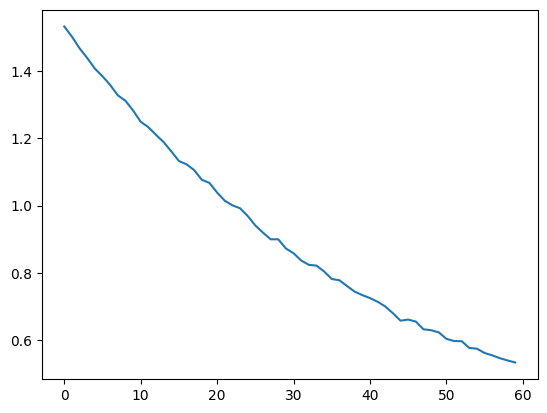

In [31]:
import matplotlib.pyplot as plt
plt.plot(lossvalues)
plt.show()

## BLEU score calculation

The BLEU score (the Bilingual Evaluation Understudy Score) is an evaluation metric used to calculate the capacity of our model to make correct predictions. It finds maximal n-gram matches between predicted sentences and reference sentences You can learn more about BLEU from [this tutorial](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/).


In [32]:
!pip install nltk

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
     |████████████████████████████████| 771 kB 1.5 MB/s eta 0:00:01
  Using cached click-8.1.3-py3-none-any.whl (96 kB)


In [33]:
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

# Set dropout layers to eval mode

encoder.eval()
decoder.eval()

# Initialize search module

searcher = GreedySearchDecoder(encoder, decoder)
gram1_bleu_score = []
gram2_bleu_score = []
for i in range(0,len(testpairs),1):
    input_sentence = testpairs[i][0]
    reference = testpairs[i][1:]
    templist = []
    for k in range(len(reference)):
        if(reference[k]!=''):
            temp = reference[k].split(' ')
            templist.append(temp)

    input_sentence = normalizeString(input_sentence)
    output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
    output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
    chencherry = SmoothingFunction()
    #   print(output_words)
    #   print(templist)
    score1 = sentence_bleu(templist, output_words, weights=(1, 0, 0, 0), smoothing_function=chencherry.method1)
    score2 = sentence_bleu(templist, output_words, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method1) 
    gram1_bleu_score.append(score1)
    gram2_bleu_score.append(score2)
    if i%1000 == 0:
        print(i,sum(gram1_bleu_score)/len(gram1_bleu_score),sum(gram2_bleu_score)/len(gram2_bleu_score))

print("Total Bleu Score for 1 grams on testing pairs: ", sum(gram1_bleu_score)/len(gram1_bleu_score) )  
print("Total Bleu Score for 2 grams on testing pairs: ", sum(gram2_bleu_score)/len(gram2_bleu_score) )

0 0.141080287481769 0.04887164517296948
1000 0.14486652151483806 0.05648401208840063
2000 0.14349773151431605 0.05774226989864686
3000 0.1442626894580073 0.05670756043794812
4000 0.14645918959735982 0.05687010371114861
5000 0.14604592652874726 0.056894258986968024
6000 0.1449591609032516 0.05560352866317366
7000 0.15289882827144163 0.06448624944841967
8000 0.15152331541556702 0.06340003790326638
Total Bleu Score for 1 grams on testing pairs:  0.15071891013513827
Total Bleu Score for 2 grams on testing pairs:  0.0629337545965211


In [36]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)
# input
# Hi, how are you?
# What
# I don't understand you
# hmm, good bye

## Beam search

Beam search is an improved version of greedy search. It has a hyperparameter named beam size,  $k$. At time step 1, selecting $k$ tokens with the highest conditional probabilities. Each of them will be the first token of $k$ candidate output sequences, respectively. At each subsequent time step, based on the $k$ candidate output sequences at the previous time step, $k$ candidate output sequences has been selected with the highest conditional probabilities from $k|\gamma|$ possible choices.

<img src="img/lstm_beamsearch.PNG" title="Beam search" style="width: 640px;" />

the sequence with the highest of the following score as the output sequence has been chosen from the equation:

$\frac{1}{L^{\alpha}}\log{P(y_1,...,y_L)} = \frac{1}{L^{\alpha}} \sum_{t'=1}^{L} \log{P(y_{t'}|t_1,...,y_{t'-1}, c)}$

Where $L$ is the length of the final candidate sequence and $\alpha$ is usually set to 0.75.

## **Beam Decoder**

The difference between greedy search and beam search is decoder function. Thus, greedy search function name is greedy_decode, and beam search function name is beam_decode.

In [37]:
class Sentence:
    def __init__(self, decoder_hidden, last_idx=SOS_token, sentence_idxes=[], sentence_scores=[]):
        if(len(sentence_idxes) != len(sentence_scores)):
            raise ValueError("length of indexes and scores should be the same")
        self.decoder_hidden = decoder_hidden
        self.last_idx = last_idx
        self.sentence_idxes =  sentence_idxes
        self.sentence_scores = sentence_scores

    def avgScore(self):
        if len(self.sentence_scores) == 0:
            raise ValueError("Calculate average score of sentence, but got no word")
        # return mean of sentence_score
        return sum(self.sentence_scores) / len(self.sentence_scores)

    def addTopk(self, topi, topv, decoder_hidden, beam_size, voc):
        topv = torch.log(topv)
        terminates, sentences = [], []
        for i in range(beam_size):
            if topi[0][i] == EOS_token:
                terminates.append(([voc.index2word[idx.item()] for idx in self.sentence_idxes] + ['<EOS>'],
                                   self.avgScore())) 
                continue
            idxes = self.sentence_idxes[:] 
            scores = self.sentence_scores[:] 
            idxes.append(topi[0][i])
            scores.append(topv[0][i])
            sentences.append(Sentence(decoder_hidden, topi[0][i], idxes, scores))
        return terminates, sentences

    def toWordScore(self, voc):
        
        words = []
        for i in range(len(self.sentence_idxes)):
            if self.sentence_idxes[i] == EOS_token:
                words.append('<EOS>')
            else:
                words.append(voc.index2word[self.sentence_idxes[i].item()])
       
        if self.sentence_idxes[-1] != EOS_token:
            words.append('<EOS>')
        return (words, self.avgScore())

    def __repr__(self):
        res = f"Sentence with indices {self.sentence_idxes} "
        res += f"and scores {self.sentence_scores}"
        return res


def beam_decode(decoder, decoder_hidden, encoder_outputs, voc, beam_size, max_length=MAX_LENGTH):
    terminal_sentences, prev_top_sentences, next_top_sentences = [], [], []
    prev_top_sentences.append(Sentence(decoder_hidden))
    for i in range(max_length):
        
        for sentence in prev_top_sentences:
            decoder_input = torch.LongTensor([[sentence.last_idx]])
            decoder_input = decoder_input.to(device)

            decoder_hidden = sentence.decoder_hidden
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(beam_size)
            term, top = sentence.addTopk(topi, topv, decoder_hidden, beam_size, voc)
            terminal_sentences.extend(term)
            next_top_sentences.extend(top)
           
        
        next_top_sentences.sort(key=lambda s: s.avgScore(), reverse=True)
        prev_top_sentences = next_top_sentences[:beam_size]
        next_top_sentences = []
        

    terminal_sentences += [sentence.toWordScore(voc) for sentence in prev_top_sentences]
    terminal_sentences.sort(key=lambda x: x[1], reverse=True)

    n = min(len(terminal_sentences), 15)
    return terminal_sentences[:n]


class BeamSearchDecoder(nn.Module):

    def __init__(self, encoder, decoder, voc, beam_size=10):
        super(BeamSearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.voc = voc
        self.beam_size = beam_size

    def forward(self, input_seq, input_length, max_length):
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]
        
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        sentences = beam_decode(self.decoder, decoder_hidden, encoder_outputs, self.voc, self.beam_size, max_length)
        
        
        all_tokens = [torch.tensor(self.voc.word2index.get(w, 0)) for w in sentences[0][0]]
        return all_tokens, None

    def __str__(self):
        res = f"BeamSearchDecoder with beam size {self.beam_size}"
        return res

In [38]:
model_name = 'cb_model'
attn_model = 'dot'

hidden_size = 512
encoder_n_layers = 2
decoder_n_layers = 4
dropout = 0.5
batch_size = 256 
loadFilename = None

embedding = nn.Embedding(voc.num_words, hidden_size)
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
encoder = encoder.to(device)
decoder = decoder.to(device)

In [39]:
save_dir = 'content/'
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 6000
print_every = 100
save_every = 2000
loadFilename = None
corpus_name="Chat"
encoder.train()
decoder.train()
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
print("Starting Training!")
lossvalues = trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Starting Training!
Initializing ...
Training...
Iteration: 100; Percent complete: 1.7%; Average loss: 5.3312
Iteration: 200; Percent complete: 3.3%; Average loss: 4.6112
Iteration: 300; Percent complete: 5.0%; Average loss: 4.3657
Iteration: 400; Percent complete: 6.7%; Average loss: 4.2144
Iteration: 500; Percent complete: 8.3%; Average loss: 4.1002
Iteration: 600; Percent complete: 10.0%; Average loss: 4.0153
Iteration: 700; Percent complete: 11.7%; Average loss: 3.9419
Iteration: 800; Percent complete: 13.3%; Average loss: 3.8706
Iteration: 900; Percent complete: 15.0%; Average loss: 3.8051
Iteration: 1000; Percent complete: 16.7%; Average loss: 3.7504
Iteration: 1100; Percent complete: 18.3%; Average loss: 3.6711
Iteration: 1200; Percent complete: 20.0%; Average loss: 3.6200
Iteration: 1300; Percent complete: 21.7%; Average loss: 3.5638
Iteration: 1400; Percent complete: 23.3%; Average loss: 3.5285
Iteration: 1500; Percent complete: 25.0%; Average loss: 3.4866
Iteration: 1600; Perc

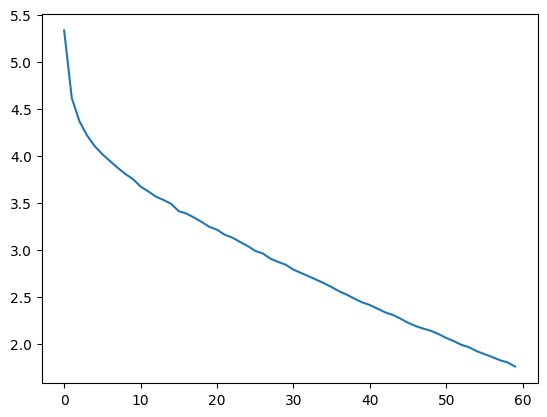

In [40]:
import matplotlib.pyplot as plt

plt.plot(lossvalues)
plt.show()

## BLEU score calculation

Let's calculate the BLEU score with the beam search decoder:

In [44]:
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

# Set dropout layers to eval mode

encoder.eval()
decoder.eval()

# Initialize search module

############################################################################
# Difference between greedy search and beam search is here

# greedy search
# searcher = GreedySearchDecoder(encoder, decoder)

# beam search
searcher = BeamSearchDecoder(encoder, decoder, voc, 3)
############################################################################
gram1_bleu_score = []
gram2_bleu_score = []

for i in range(0,len(testpairs),1):
    input_sentence = testpairs[i][0]
  
    reference = testpairs[i][1:]
    templist = []
    for k in range(len(reference)):
        if(reference[k]!=''):
            temp = reference[k].split(' ')
            templist.append(temp)
  
    input_sentence = normalizeString(input_sentence)
    output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
    output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
    chencherry = SmoothingFunction()
    score1 = sentence_bleu(templist,output_words,weights=(1, 0, 0, 0) ,smoothing_function=chencherry.method1)
    score2 = sentence_bleu(templist,output_words,weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1) 
    gram1_bleu_score.append(score1)
    gram2_bleu_score.append(score2)
    if i%1000 == 0:
        print(i,sum(gram1_bleu_score)/len(gram1_bleu_score),sum(gram2_bleu_score)/len(gram2_bleu_score))
        
print("Total Bleu Score for 1 grams on testing pairs: ", sum(gram1_bleu_score)/len(gram1_bleu_score))  
print("Total Bleu Score for 2 grams on testing pairs: ", sum(gram2_bleu_score)/len(gram2_bleu_score))  

0 0.0410424993119494 0.018354763685601443
1000 0.157693146906442 0.07392119413849015
2000 0.15079172559214074 0.07119890627769766
3000 0.1510645002187276 0.07070713185038048
4000 0.15122926199063336 0.06941732200622022
5000 0.15008045753127336 0.06861731779853417
6000 0.14757175094065347 0.06640383800018033
7000 0.15347957390871608 0.07193919729994885
8000 0.1522411032125378 0.07106922737540426
Total Bleu Score for 1 grams on testing pairs:  0.15188191951031715
Total Bleu Score for 2 grams on testing pairs:  0.07072690010961603


## Chat with the beam search bot

Let's chat with the new chatbot:

In [45]:
encoder.eval()
decoder.eval()
searcher = BeamSearchDecoder(encoder, decoder, voc, 3)
evaluateInput(encoder, decoder, searcher, voc)

Bot: hi .
Bot: you know what i m doing
Bot: fine i m okay .
Bot: i m not sure . i m sorry .
Bot: goodbye bye . i m sorry .
Bot: i m sorry .
Bot: yes ?
Bot: yes ?
Bot: yes ?
Bot: yes ?
Bot: why do you want to do about it ?
Bot: what do you mean ?
Bot: i m sorry .
Bot: what do you want to do ?
Bot: i m sorry . i m sorry .
Bot: yes ?


## Independent work

To be done on your own:

1. Find another dataset of sentence pairs in a different domain and see
   if you can preprocess the data and train a chatbot model on it using the same code we developed today. Report your results.

2. Replace the LSTM encoder/decoder with a Transformer. Check out the [PyTorch Transformer module documentation](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)
